In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

## Let's try it!

### Image preprocessing

In [3]:
#img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/data/1.jpg"
img_path = "/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/new_chess_data/boards/board1.jpeg"
img = cv.imread(img_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

(1280, 1280)

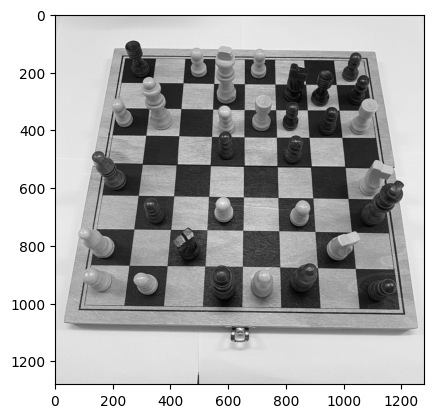

In [379]:
plt.imshow(img_gray,cmap="gray")

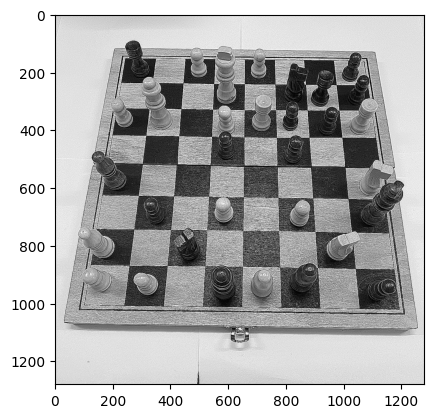

In [380]:
kernel = np.ones((5, 5), np.uint8)
kernel_sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharp = cv.filter2D(img_gray, -1, kernel_sharp)

#img_erosion = cv.erode(blur, kernel, iterations=4)
#img_dilation = cv.dilate(blur, kernel, iterations=3)

plt.imshow(img_sharp, cmap="gray")

### Processing and corners

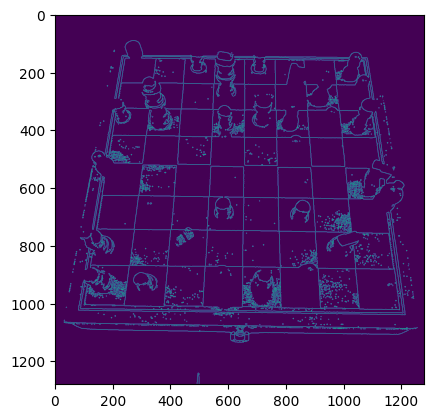

In [381]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
v = np.median(img)
thres = cv.threshold(img_gray,140,255,cv.THRESH_BINARY)
blur = cv.blur(img_gray,(3,3),0)
edges = cv.Canny(thres[1], 140, 400) #70,250 for old
plt.imshow(edges)

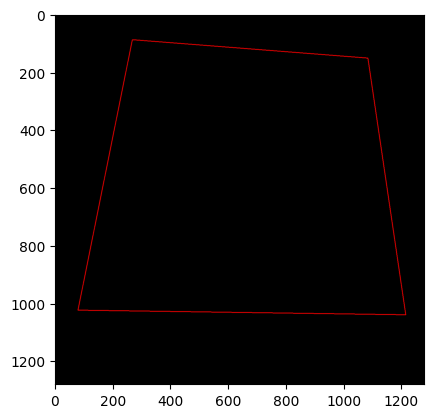

In [382]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_black = np.zeros((1280, 1280, 3), dtype = np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
dilated = cv.dilate(edges, kernel, iterations=2)

contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for idx, contour in enumerate (contours):
    # Approximate the contour shape to a polygon
    peri = cv.arcLength(contour, True)
    if peri > 2500:
        polygon = cv.approxPolyDP(contour, epsilon=0.05*cv.arcLength(contour, True), closed=False)
        sides = len(polygon)
        if sides == 3:
            pass
            #cv.drawContours(img_black, [polygon], 0, (0, 255, 0), 2)
        elif sides == 4:
            cv.drawContours(img_black, [polygon], 0, (0, 0, 255), 2)
        else:
            real_one = idx
            cv.drawContours(img_black, [polygon], 0, (255, 0, 0), 2)
plt.imshow(img_black)

4


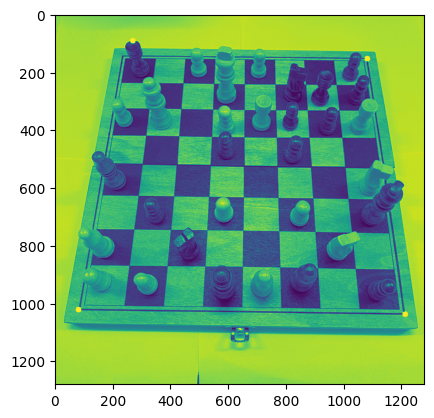

In [383]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_b = cv.cvtColor(img_black, cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(img_gray_b, 4, 0.4, 600)
corners = np.int0(corners)
point_corners = []
for corner in corners:
    x, y = corner.ravel()
    cv.circle(img_gray, (x,y), 10, 255, -1)
    point_corners.append([x,y])
print(len(point_corners))
point_corners = sorted(point_corners)
plt.imshow(img_gray)

In [384]:
pts = np.array(point_corners)
center = np.mean(pts, axis=0)

# Sort the points in clockwise
cyclic_pts = [
        # Top-left
        pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] < center[1]))[0][0], :],
        # Top-right
        pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] < center[1]))[0][0], :],
        # Bottom-Right
        pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] > center[1]))[0][0], :],
        # Bottom-Left
        pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] > center[1]))[0][0], :]]

point_corners = pts.tolist()

0
[81, 1022]
3
[1211, 1038]
2
[1080, 154]
1
[269, 92]


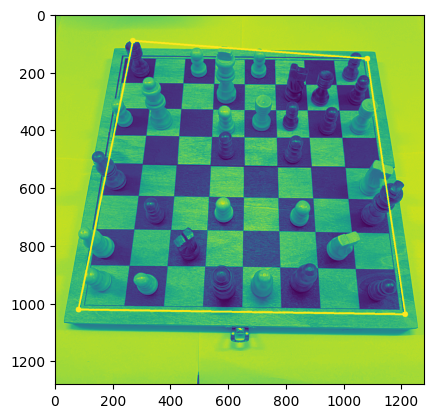

In [385]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    print(point_corners[c])
    cv.line(img_gray, point_corners[c], point_corners[c-1], color = 255, thickness=5)
    i -=1
    
plt.imshow(img_gray)

In [386]:
def split_line(points1, points2, nb):
    x = np.linspace(points1[0],points2[0],nb)
    y = (points2[1]-points1[1])/(points2[0]-points1[0])*(x-points1[0]) + points1[1]
    return x, y

0
3
2
1


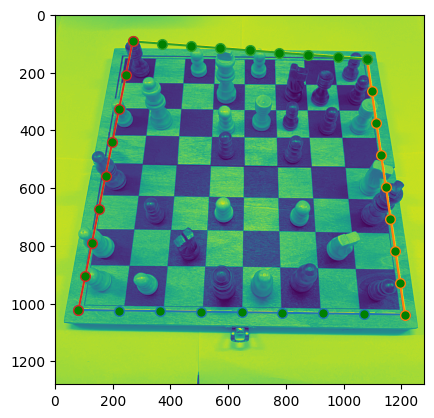

In [387]:
i = 4
while i > 0:
    c = i % 4
    print(c)
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
plt.imshow(img_gray)

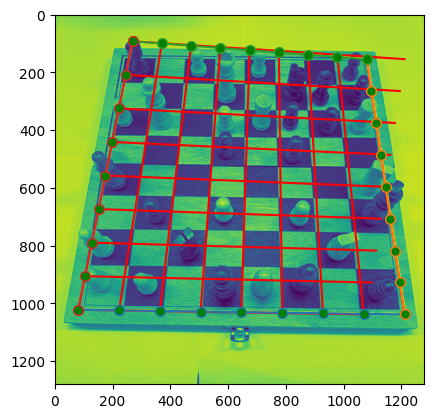

In [388]:
def line_btw_point(points1_1, points1_2, points2_1, points2_2):
    x_1, y_1 = split_line(points1_1, points1_2, 9)
    x_2, y_2 = split_line(points2_1, points2_2, 9)
    x_1 = np.sort(np.array(x_1))
    x_2 = np.sort(np.array(x_2))

    for i in range(len(x_1)):
        x = [x_1[i], x_2[i]]
        y = [y_1[i], y_2[i]]
        plt.plot(x,y, "r")
        ax = plt.gca()
        ax.set_xlim([0, 1280])
        ax.set_ylim([1280, 0])

line_btw_point(point_corners[0], point_corners[1], point_corners[3], point_corners[2])
line_btw_point(point_corners[0], point_corners[3], point_corners[1], point_corners[2])

i = 4
while i > 0:
    c = i % 4
    x1, y1 = split_line(point_corners[c], point_corners[c-1], 9)
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="green")
    i -= 1
    
plt.imshow(img_gray)

670.947021484375 584.2874755859375
1150.1680908203125 947.0675048828125
[[  71 1026]
 [ 121   80]
 [1270  142]
 [1220 1087]]


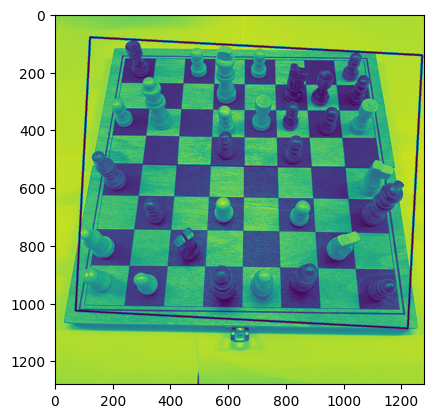

In [389]:
rotatedRect = cv.minAreaRect(contours[real_one])
(x, y), (width, height), angle = rotatedRect
rotatedRectPts = cv.boxPoints(rotatedRect)
rotatedRectPts = np.int0(rotatedRectPts)
top = rotatedRectPts[1]
bottom = rotatedRectPts[3]
print(x,y)
print(width, height)
print(rotatedRectPts)

out = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv.drawContours(out, [rotatedRectPts], 0, (0, 255, 0), 5)
plt.imshow(out)

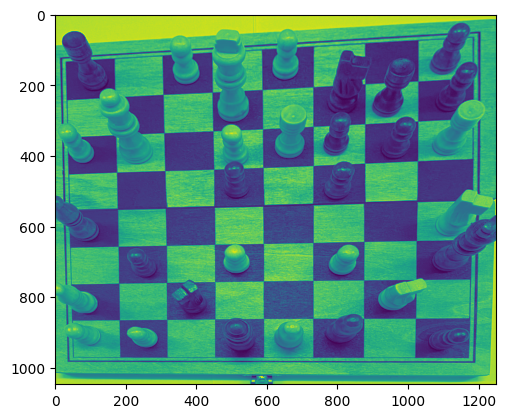

In [390]:
# bottom-left, Top-left, top-right, bottom-right
dstPts = [[0, height], [0, 0], [width, 0], [width, height]]
# Get the transform
m = cv.getPerspectiveTransform(np.float32(point_corners), np.float32(dstPts))

#add padding
padding = 50
m[0,2] += padding
m[1,2] += padding

# Transform the image
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
out = cv.warpPerspective(img_gray, m, (int(width+ 2*padding), int(height+ 2*padding)))
plt.imshow(out)

### Hough lines method

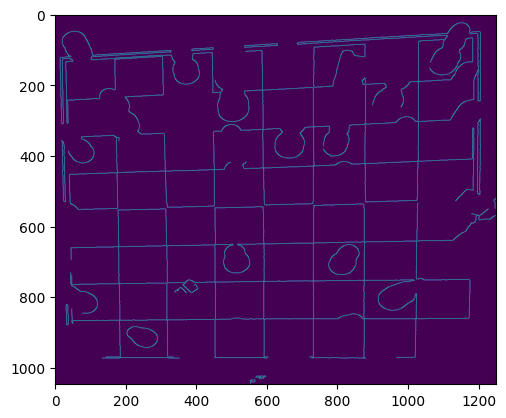

In [391]:
thres = cv.threshold(out,140,255,cv.THRESH_BINARY)
blur = cv.blur(out,(3,3),0)
edges_s = cv.Canny(blur, 170, 500) #70,250 for old
plt.imshow(edges_s)

In [392]:
img_gray_2 = out.copy()
lines = cv.HoughLines(edges_s, 1, np.pi/180, 170)

In [393]:
cart_equ = []
verticality = []
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cv.line(img_gray_2, pt1, pt2, (0,0,152), 3, cv.LINE_AA)
            if b != 0:
                cart_equ.append(((-a/b), (rho/b)))
            else: verticality.append(rho)

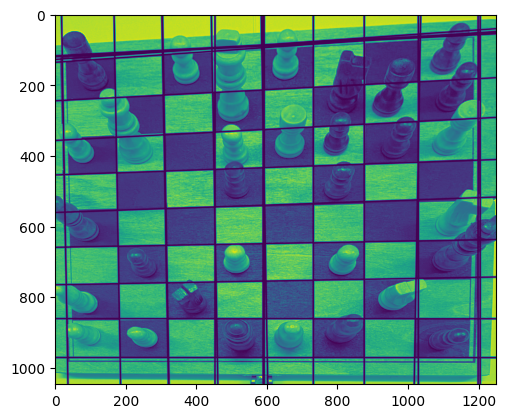

In [394]:
plt.imshow(img_gray_2)

## Hough lines conversion

### cartesian conversion

In [395]:
cart = pd.DataFrame(cart_equ).sort_values(by=1)
x_ca = cart[0]
y_ca = cart[1]

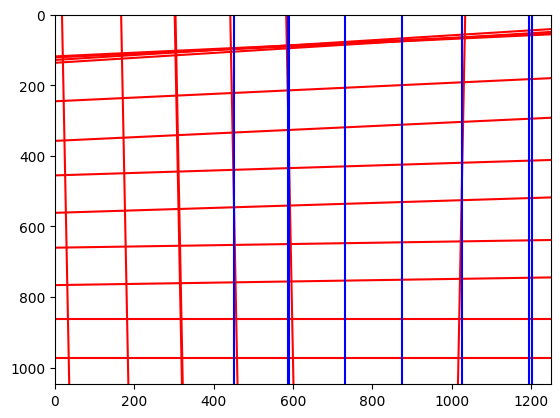

In [396]:
x = np.linspace(0,out.shape[1],len(x_ca))
for i in range(len(x_ca)):
    y = x_ca[i] * x + y_ca[i]
    plt.plot(x, y, '-r', label = f"line{i}")
    ax = plt.gca()
    ax.set_xlim([0, out.shape[1]])
    ax.set_ylim([out.shape[0], 0])
for v in verticality:
    ax.axvline(x = v, color = 'b')

### prepping the dataframe

In [397]:
from sklearn.metrics.pairwise import cosine_similarity

In [398]:
df = pd.DataFrame(lines[:,0,:]).rename(columns={0: "Rho", 1: "Theta"})
#df = df.sort_values(by="Rho")

In [399]:
df["diff"] = df["Rho"].diff() + 10*np.abs(df["Theta"].diff())
#new_lines = df[df["diff"]>8]
new_lines = df

In [400]:
new_lines["a"] = new_lines["Theta"].apply(math.cos)
new_lines["b"] = new_lines["Theta"].apply(math.sin)
new_lines["slope"] = -new_lines["a"]/new_lines["b"]
new_lines["intercept"] = new_lines["Rho"]/new_lines["b"]

mask_vert = (np.abs(new_lines["a"]) > 0.99) & (np.abs(new_lines["b"]) < 0.1 )
mask = new_lines.isin([np.inf]).any(axis=1)
vertical_2 = new_lines[mask + mask_vert]
horizontal = new_lines[~(mask + mask_vert)]

### Filtering the lines

In [401]:
horizontal = horizontal.sort_values(by="intercept")
horizontal["diff"] = horizontal["intercept"].diff()
horizontal_f = horizontal[(horizontal["diff"]>10) | horizontal["diff"].isna()]
horizontal_f

,Rho,Theta,diff,a,b,slope,intercept
21,118.0,1.518436,NaN,5.233597e-02,0.998630,-5.240780e-02,118.161937
9,245.0,1.518436,109.004126,5.233597e-02,0.998630,-5.240780e-02,245.336225
11,357.0,1.518436,112.153703,5.233597e-02,0.998630,-5.240780e-02,357.489928
5,455.0,1.535890,97.787415,3.489949e-02,0.999391,-3.492077e-02,455.277343
24,561.0,1.535890,106.064612,3.489949e-02,0.999391,-3.492077e-02,561.341954
0,660.0,1.553343,98.758582,1.745238e-02,0.999848,-1.745504e-02,660.100536
3,766.0,1.553343,106.016147,1.745238e-02,0.999848,-1.745504e-02,766.116683
2,862.0,1.570796,95.883317,-4.371139e-08,1.000000,4.371139e-08,862.000000
4,972.0,1.570796,110.000000,-4.371139e-08,1.000000,4.371139e-08,972.000000


In [402]:
vertical_2["x_intercept"] = vertical_2["Rho"].abs()
vertical_2 = vertical_2.sort_values(by="x_intercept")
vertical_2["diff"] = np.abs(vertical_2["x_intercept"]).diff()
vertical_2_f = vertical_2[(vertical_2["diff"] > 10) | (vertical_2["diff"].isna())]
vertical_2_f

/tmp/ipykernel_838/584936983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vertical_2["x_intercept"] = vertical_2["Rho"].abs()


,Rho,Theta,diff,a,b,slope,intercept,x_intercept
23,-18.0,3.124139,NaN,-0.999848,0.017452,57.28979,-1.031373e+03,18.0
6,-167.0,3.124139,149.0,-0.999848,0.017452,57.28979,-9.568852e+03,167.0
14,-302.0,3.124139,135.0,-0.999848,0.017452,57.28979,-1.730415e+04,302.0
7,-442.0,3.124139,138.0,-0.999848,0.017452,57.28979,-2.532594e+04,442.0
22,-583.0,3.124139,131.0,-0.999848,0.017452,57.28979,-3.340504e+04,583.0
1,730.0,0.000000,139.0,1.000000,0.000000,-inf,inf,730.0
8,874.0,0.000000,144.0,1.000000,0.000000,-inf,inf,874.0
17,1027.0,0.000000,153.0,1.000000,0.000000,-inf,inf,1027.0
26,1196.0,0.000000,162.0,1.000000,0.000000,-inf,inf,1196.0


### Displaying the lines

[-0.05240779668099624, -0.05240779668099624, -0.0699268498320731, -0.0699268498320731, -0.05240779668099624, -0.05240779668099624, -0.03492076648448904, -0.03492076648448904, -0.017455041563608085, -0.017455041563608085, 4.371139000186246e-08, 4.371139000186246e-08, -57.28996207463862]


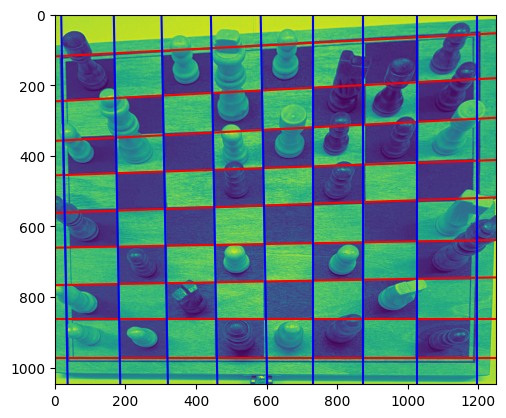

In [403]:
x = np.linspace(0,out.shape[1],len(new_lines))
x_h = horizontal_f["slope"].tolist()
y_h = horizontal_f["intercept"].tolist()
print(x_c)
for i in range(len(x_h)):
    y = x_h[i] * x + y_h[i]
    plt.plot(x, y, '-r', label = f"line{i}")
    ax = plt.gca()
    ax.set_xlim([0, out.shape[1]])
    ax.set_ylim([out.shape[0], 0])

vert = vertical_2_f["Rho"].tolist()
x_v = vertical_2_f["slope"].tolist()
y_v = vertical_2_f["intercept"].tolist()
for i in range(len(x_v)):
    if x_v[i] == np.inf or x_v[i] == -np.inf:
        plt.axvline(x = vert[i], color = 'b')
    else: 
        y = x_v[i] * x + y_v[i]
        plt.plot(x, y, '-b', label = f"line{i}")
plt.imshow(out)

### intersections

In [404]:
def intersection(line1, line2):
    if np.inf not in [line1[0], line1[1], line2[0], line2[1]] or -np.inf not in [line1[0], line1[1], line2[0], line2[1]]:
        x0 = (line2[1] - line1[1]) / (line1[0] - line2[0])
        y0 = line1[0] * x0 + line1[1]
    else:
        if np.inf in line1 or -np.inf in line1:
            linev = line1
            linenv = line2
        else:
            linev = line2
            linenv = line1
        x0 = linev[2]
        y0 = linenv[0] * x0 + linenv[1]
        
    return x0, y0

In [405]:
total_lines = pd.concat([horizontal_f, vertical_2_f])

In [406]:
intersections_p = []

x_l = total_lines["slope"]
y_l = total_lines["intercept"]
r_l = total_lines["Rho"]

for x1,y1,r1 in zip(x_l, y_l, r_l):
    for x2,y2,r2 in zip(x_l, y_l, r_l):
        line1 = (x1, y1, r1)
        line2 = (x2, y2, r2)
        if line1 != line2:
            if line1[0] - line2[0] != 0:
                x0, y0 = intersection(line1, line2)
                intersections_p.append((round(x0,0), round(y0,0)))

In [407]:
intersections_pd = pd.DataFrame(intersections_p)
intersections_pd = intersections_pd[intersections_pd>0][intersections_pd<1281].dropna().drop_duplicates().reset_index()
x_in = intersections_pd[0].to_list()
y_in = intersections_pd[1].to_list()
intersections_pd

,index,0,1
0,6,20.0,117.0
1,7,169.0,109.0
2,8,304.0,102.0
3,9,444.0,95.0
4,10,585.0,88.0
...,...,...,...
76,136,600.0,972.0
77,137,730.0,972.0
78,138,874.0,972.0
79,139,1027.0,972.0


### plotting from DataFrame

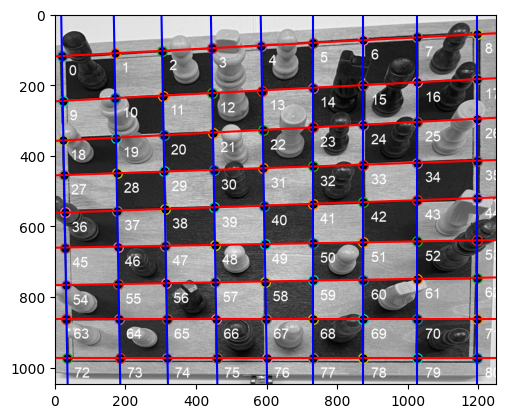

In [408]:
fig = plt.figure()
x = np.linspace(0,1280)
i = 0
img_2 = Image.fromarray(out)

for i in range(len(x_in)):
    text = f"{i}"
    x1 = x_in[i]
    y1 = y_in[i]
    plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="black")
    ax = plt.gca()
    ax.set_xlim([0, 1280])
    ax.set_ylim([1280, 0])
    draw = ImageDraw.Draw(img_2)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text((x1+20,y1+20),text, font=font_type, fill=255)

for i in range(len(x_h)):
    y = x_h[i] * x + y_h[i]
    plt.plot(x, y, '-r', label = f"line{i}")
    ax = plt.gca()
    ax.set_xlim([0, out.shape[1]])
    ax.set_ylim([out.shape[0], 0])

for i in range(len(x_v)):
    if x_v[i] == np.inf or x_v[i] == -np.inf:
        plt.axvline(x = vert[i], color = 'b')
    else: 
        y = x_v[i] * x + y_v[i]
        plt.plot(x, y, '-b', label = f"line{i}")

plt.imshow(img_2, cmap="gray")

## Coordinate generation

In [409]:
intersection_pd = intersections_pd.drop(columns="index")

In [410]:
A0 = intersection_pd.loc[0].to_list()
A0

[20.0, 117.0]

In [411]:
coordinate = {}
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
i = 0
for col in letters:
    for line in range(8):
        val = intersection_pd.loc[0+i + 9*line].to_list()
        text = f"{col}{line}"
        coordinate[text] = val
    i += 1
coordinate

{'A0': [20.0, 117.0],
 'A1': [22.0, 244.0],
 'A2': [24.0, 356.0],
 'A3': [26.0, 454.0],
 'A4': [28.0, 560.0],
 'A5': [30.0, 660.0],
 'A6': [31.0, 766.0],
 'A7': [33.0, 862.0],
 'B0': [169.0, 109.0],
 'B1': [171.0, 236.0],
 'B2': [173.0, 348.0],
 'B3': [175.0, 449.0],
 'B4': [177.0, 555.0],
 'B5': [178.0, 657.0],
 'B6': [180.0, 763.0],
 'B7': [182.0, 862.0],
 'C0': [304.0, 102.0],
 'C1': [306.0, 229.0],
 'C2': [308.0, 341.0],
 'C3': [310.0, 444.0],
 'C4': [312.0, 550.0],
 'C5': [313.0, 655.0],
 'C6': [315.0, 761.0],
 'C7': [317.0, 862.0],
 'D0': [444.0, 95.0],
 'D1': [446.0, 222.0],
 'D2': [448.0, 334.0],
 'D3': [450.0, 440.0],
 'D4': [452.0, 546.0],
 'D5': [453.0, 652.0],
 'D6': [455.0, 758.0],
 'D7': [457.0, 862.0],
 'E0': [585.0, 88.0],
 'E1': [587.0, 215.0],
 'E2': [589.0, 327.0],
 'E3': [591.0, 435.0],
 'E4': [593.0, 541.0],
 'E5': [594.0, 650.0],
 'E6': [596.0, 756.0],
 'E7': [598.0, 862.0],
 'F0': [730.0, 80.0],
 'F1': [730.0, 207.0],
 'F2': [730.0, 319.0],
 'F3': [730.0, 430.0],

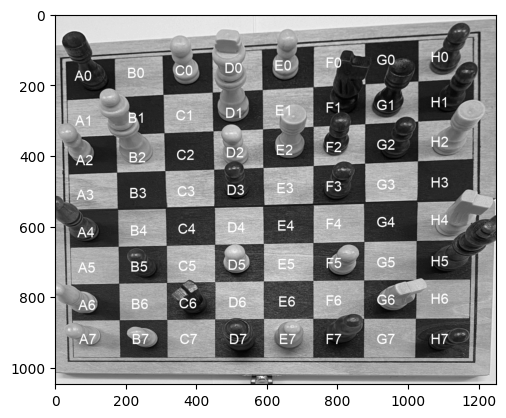

In [412]:
img_3 = Image.fromarray(out)
for key, value in coordinate.items():
    text = key
    pos = (value[0]+35, value[1]+35)
    draw = ImageDraw.Draw(img_3)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(pos,text, font=font_type, fill=255)
plt.imshow(img_3, cmap="gray")

## Colour detection

In [413]:
def pix_val(img, coor):
    return img.getpixel(coor)

In [414]:
def detect_colour(val):
    if val > 125:
        return "White"
    else: return "Black"

In [415]:
img_color = Image.fromarray(out)
img_gray_pil = ImageOps.grayscale(img_color)

In [416]:
pick_A0 = (coordinate["A0"][0]+15, coordinate["A0"][1]+23)
pick_A7 = (coordinate["A7"][0]+15, coordinate["A7"][1]+23)
pick_H0 = (coordinate["H0"][0]+15, coordinate["H0"][1]+23)
pick_H7 = (coordinate["H7"][0]+15, coordinate["H7"][1]+23)

points = [pick_A0, pick_A7, pick_H0, pick_H7]

In [417]:
points[0]

(35.0, 140.0)

In [418]:
for point in points:
    text = detect_colour(pix_val(img_gray_pil, point))
    draw = ImageDraw.Draw(img_gray_pil)
    font_type = ImageFont.truetype("arial.ttf", 40)
    draw.text(point,text, font=font_type, fill=255)

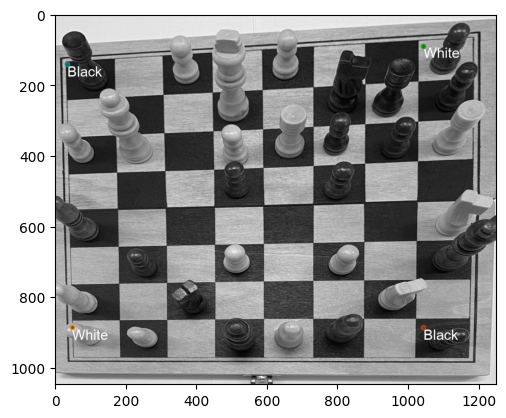

In [419]:
plt.plot(pick_A0[0],pick_A0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_A7[0],pick_A7[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H0[0],pick_H0[1], marker="o", markersize=3, markerfacecolor="green")
plt.plot(pick_H7[0],pick_H7[1], marker="o", markersize=3, markerfacecolor="green")
plt.imshow(img_gray_pil, cmap="gray")